# Hierarchisches Clustering

Erklärung: Everitt Kap. 4

Die Ergebnisse von hierarch. Clustering will man üblicherweise wie auch von Everitt dargestellt mit einem Dendrogram präsentieren. Das ist Python leider nicht ganz einfach, da die einschlägige Visualisierungsmethode in scipy (scipy.cluster.hierarchy.dendrogram) als Eingabe nur eine linkage matrix akzeptiert, wie sie von dem einschlägigen Verfahren zum hierarch. Clustering in Scipy erzeugt wird (siehe scipy.cluster.hierarchy.linkage) - aber eben nicht von Scikit-Learn. Nun gibt es zwei Auswege: 1. Man macht sein hierch. Clustering mit Scipy, 2. Man baut seine eigene *linkage matrix*. Wir wählen hier den zweiten.

In [23]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform

from matplotlib import pyplot as plt
import numpy as np

Zuerst erzeugen wir künstliche Datenpunkte:

In [2]:
X, y = make_blobs(n_samples=12, n_features=20, centers=3, random_state=2)

Um eine gewisse Vorstellung der Struktur zu haben, visualisieren wir sie mit PCA: 

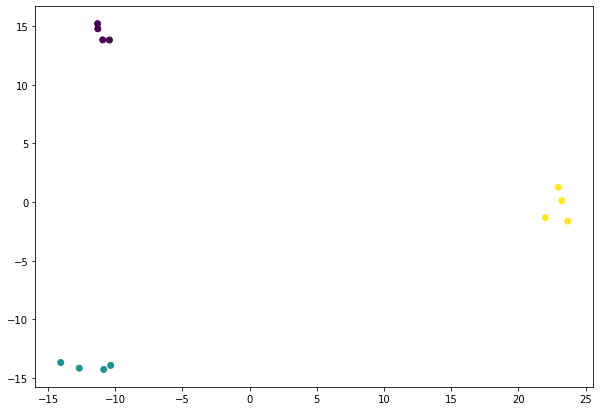

In [3]:
X_tf = PCA(2).fit_transform(X)
plt.figure(figsize=(10,7))
plt.scatter(X_tf[:,0], X_tf[:, 1], c=y);

Jetzt verwenden wir die einschlägige Klasse **AgglomerativeClustering()** in der gleichen Weise wie alle anderen Klassen in Scikit-Learn. Mit einem kleinen Unterschied: Wir geben zwei Parameter explizit an, da wir sonst mit einem Bug in Scikit-Learn v. 0.23 zu kämpfen haben:

In [4]:
# bug in AgglomerativeClustering: distances_ is not always available, you have 
# to set n_clusters and distance_threshold explicitly
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X)

Anders als bei KMeans ist hier nicht model.labels_ relevant, da dies nur die Informationen zu unseren 12 Datenpunkten enthält:

In [5]:
model.labels_

array([ 9,  6,  7, 11,  8, 10,  4,  3,  1,  5,  2,  0], dtype=int64)

Was wir aber wissen wollen, ist: Welche Datenpunkte sind zu einem Cluster verbunden worden. Das finden wir unter dem Attribut children_. Es handelt sich um einen Array in der Form (n, 2), wobei n die Anzahl der Cluster anzeigt. Jeder Eintrag zeigt an, welche Cluster miteinander verbunden wurden, zuerst z.B. die Datenpunkte 3 und 6. Dann 8 und 9 usw. In der 5. Zeile, [2, 14], sehen wir etwas Auffälliges: Wir haben ja nur 12 Datenpunkte (=n_samples). Jede Zeile erzeugt ein neues Cluster; gezählt wird ab der Anzahl der Samples. [3, 6] ist also Cluster 12, [8, 9] ist Cluster 13 usw.:

In [6]:
print(model.children_.shape)
model.children_[:]

(11, 2)


array([[ 3,  6],
       [ 8,  9],
       [ 5,  7],
       [ 4, 10],
       [ 2, 14],
       [ 1, 15],
       [12, 13],
       [ 0, 16],
       [11, 17],
       [18, 20],
       [19, 21]], dtype=int64)

Außerdem gibt es eine Liste  mit Distanzen: distances_. Sie hat so viele Einträge wie children_ und bezieht sich auf dessen Einträge, d.h. der erste Wert ist die Distanz zwischen den beiden Datenpunkten des ersten Eintrag von children_, usw.:

In [7]:
print(model.distances_.shape)
model.distances_

(11,)


array([ 5.16909643,  5.4027639 ,  5.80568351,  6.45307436,  6.74684467,
        6.77790346,  6.93856175,  7.1487572 ,  8.09120854, 56.82086003,
       79.60114892])

## Visualisierung mit Dendrogrammen

Wie oben schon erwähnt, müssen wir, wenn wir das Ergebnis visualisieren wollen, eine linkage matrix bauen, die wir dann der Visualisierungsmethode aus scipy als Eingabe geben können

Die Linkage Matrix ist nun eine Liste von Listen, die soviele Zeilen hat wie children_ / distances_ Einträge haben und außerdem 4 Spalten. Die ersten beiden Spalten sind identisch mit den Werten von children_, die dritte enthält die Distanzen, also die Werte in distances_. Die Zahl in der vierten Spalte gibt an, wieviele originalen Datenpunkte in dem Cluster sind. So sind etwa in dem ersten Cluster [3, 6], zwei originale Datenpunkte enthalten, die einen Abstand von 5.169 haben:

```array([[ 3.        ,  6.        ,  5.16909643,  2.        ],
       [ 8.        ,  9.        ,  5.4027639 ,  2.        ],
       [ 5.        ,  7.        ,  5.80568351,  2.        ],
       [ 4.        , 10.        ,  6.45307436,  2.        ],
       [ 2.        , 14.        ,  6.74684467,  3.        ],
       [ 1.        , 15.        ,  6.77790346,  3.        ],
       [12.        , 13.        ,  6.93856175,  4.        ],
       [ 0.        , 16.        ,  7.1487572 ,  4.        ],
       [11.        , 17.        ,  8.09120854,  4.        ],
       [18.        , 20.        , 56.82086003,  8.        ],
       [19.        , 21.        , 79.60114892, 12.        ]])```

Die ersten drei Spalten haben wir ja bereits:

In [8]:
np.column_stack([model.children_, model.distances_]).astype(float)

array([[ 3.        ,  6.        ,  5.16909643],
       [ 8.        ,  9.        ,  5.4027639 ],
       [ 5.        ,  7.        ,  5.80568351],
       [ 4.        , 10.        ,  6.45307436],
       [ 2.        , 14.        ,  6.74684467],
       [ 1.        , 15.        ,  6.77790346],
       [12.        , 13.        ,  6.93856175],
       [ 0.        , 16.        ,  7.1487572 ],
       [11.        , 17.        ,  8.09120854],
       [18.        , 20.        , 56.82086003],
       [19.        , 21.        , 79.60114892]])

Nun müssen wir die vierte berechnen:

Zuerst brauchen wir eine Liste, die so lang ist, wie die Tabelle:

In [9]:
counts = np.zeros(model.children_.shape[0])

Im nächsten Schritt haben wir eine Schleife, die über die Liste der children_ geht. 

Schauen wir uns an, was in einem Durchgang passiert: 
In die Variable 'current_count' wird der Wert gespeichert, der dann zuletzt in die jeweiligen Zeile der vierten Spalte wandert.
Dann kommt eine weitere Schleife über die Elemente von 'merge'. merge ist aber nichts anderes als ein Eintrag in der Liste model.children_, die aus zwei Elementen besteht.
Die if-Abfrage prüft nun, ob der Wert kleiner ist als die Anzahl der Datenpunkte. Wenn das der Fall ist, dann handelt es ich um einen originalen Datenpunkt und der Counter wird um 1 erhöht. 
Problematischer ist es natürlich, wenn es sich dabei schon um ein Cluster handelt, man also herausfinden muss, wieviele originale Datenpunkte in dem Cluster sind. Das steht hier unter 'else'.  An dieser Stelle kann man sich zunutze machen, dass unsere Liste counts, die wir gerade aufbauen, ja diese Information bereits enthält. Der erste Eintrag ist die Zahl der originalen Datenpunkte in dem Cluster 12 (=n_samples), der zweite Eintrag ist die Zahl der originalen Datenpunkte in dem Cluster 13 (n_samples+1). Wir müssen also nur die Anzahl der Samples von der Cluster-Zahl abziehen (child_idx - n_samples), um den einschlägigen Wert aus der Liste counts ziehen zu können und dem current_count zuzuschlagen.

In [10]:
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


Jetzt haben wir mit counts die vierte Spalte für die linkage matrix:

In [11]:
counts

array([ 2.,  2.,  2.,  2.,  3.,  3.,  4.,  4.,  4.,  8., 12.])

Jetzt bauen wir das noch in eine Matrix und wir sind fertig:

In [12]:
np.column_stack([model.children_, model.distances_, counts]).astype(float)

array([[ 3.        ,  6.        ,  5.16909643,  2.        ],
       [ 8.        ,  9.        ,  5.4027639 ,  2.        ],
       [ 5.        ,  7.        ,  5.80568351,  2.        ],
       [ 4.        , 10.        ,  6.45307436,  2.        ],
       [ 2.        , 14.        ,  6.74684467,  3.        ],
       [ 1.        , 15.        ,  6.77790346,  3.        ],
       [12.        , 13.        ,  6.93856175,  4.        ],
       [ 0.        , 16.        ,  7.1487572 ,  4.        ],
       [11.        , 17.        ,  8.09120854,  4.        ],
       [18.        , 20.        , 56.82086003,  8.        ],
       [19.        , 21.        , 79.60114892, 12.        ]])

Der Einfachheit halber können wir das in eine Methode fassen:

In [13]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

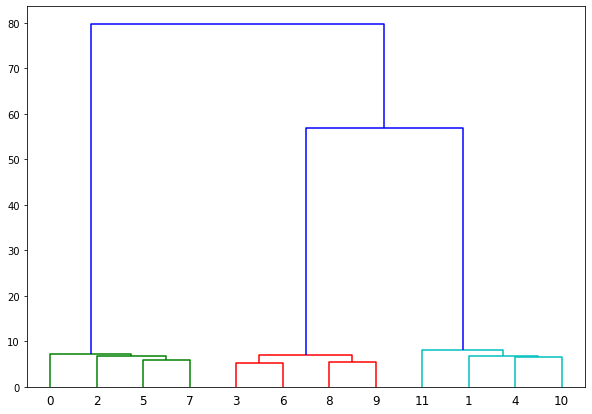

In [14]:
lmatrix = linkage_matrix(X.shape[0], model.children_, model.distances_)
plt.figure(figsize=(10,7))
dendrogram(lmatrix);

Ein weiteres Beispiel: Das Iris-Datenset

In [15]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

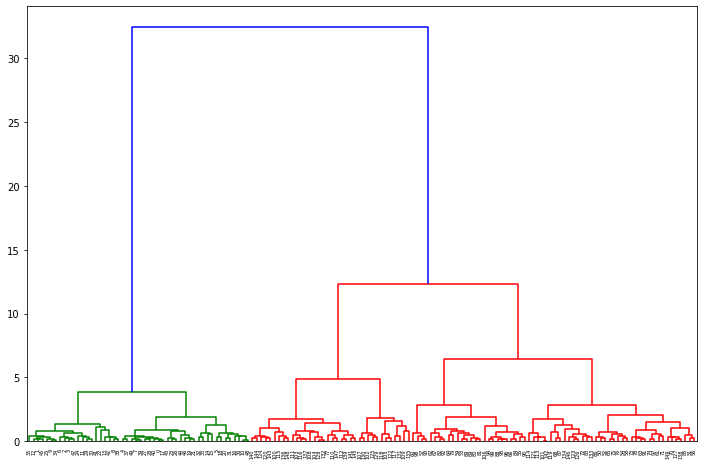

In [16]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X)
link_matrix = linkage_matrix(X.shape[0], model.children_, model.distances_)
plt.figure(figsize=(12,8))
dendrogram(link_matrix);

## Verbindungskriterien

Bei jedem Schritt des agg. Clusterings wird das nächste Cluster hinzugefügt. Aber was heißt in diesem Kontext 'ds nächste'. Es haben sich eine Reihe von Verfahren etabliert; hier diejenigen, die Scikit-learn implementiert:
* ward: minimiert* die Summe der quadrierten Differenzen, also die Varianz, innerhalb aller Cluster 
* complete/maximum: minimiert die maximale Distanz zwischen einem Paar von Clustern
* average: minimiert den Durchschnitt der Distanzen aller Instanzen eines Paars von Clustern
* single: minimiert die Distanz zwischen den kürzesten Verbindungen eine Paars von Clustern

Davon ist ward das gebräuchlichste und auch die Voreinstellung in sklearn.

\* sucht den kleinsten Wert

Hier eine interessante Grafik aus der Dokumentation von sklearn, die den Effekt der unterschiedlichen Linkage-Verfahren zeigt:
<img src='sklearn_doku_linkage_comparison.png' width=500>

# Bewertungskriterien für das Ergebnis eines Clustering

Ausführliche Diskussion in Hui Xiong: Clustering Validation Measures. 

Wir unterscheiden: 
* externe Verfahren, bei denen wir Zugriff auf die wahren Labels haben
* interne Verfahren, bei denen wir keinen Zugriff auf die wahren Labels haben

## Adjusted Rand Index

Wichtiges externes Verfahren.  Vergleicht die Cluster-Zuweisung durch den Algorithmus (K) mit der wahren Zuweisung (C). 

ARI hat einen Wert zwischen -1 und +1, wobei Werte nahe +1 ein sehr gutes Ergebnis anzeigen, Werte um die 0 eine Zufallsverteilung indizieren und Werte nahe -1 ein nicht zufälliges, aber falsches Labeling anzeigen.

Berechnung des noch nicht korrigierten Rand Index:

a: die Anzahl der Paare, die in C in einem Cluster sind und die in K in einem Cluster sind.

b: die Anzahl der Paare, die in C nicht in einem Cluster sind und die in K nicht in einem Cluster sind.

In der Sprache des Information Retrieval können wir also auch sagen: 

a: True positives

b: True negatives


$$ RI = \frac{a + b}{\binom n 2}$$  

Im Nenner steht die Anzahl aller möglichen Paare:  $\binom n 2$ (berechnet durch $n(n-1)/2$

Der Rand Index hat nun den Nachteil, dass er nicht berücksichtigt, dass schon aufgrund einer Zufallsverteilung Elemente in dem gleichen Cluster liegen können (und wahrscheinlich werden). Deshalb verwendet man üblicherweise den korrigierten (adjusted) Rand Index. Dabei wird vom berechneten RI der Erwartungswert abgezogen:

$$ARI = \frac{Rand Index-Expected Rand Index}{Maximum Rand Index - Expected Rand Index}$$

In scikit-learn findet sich der ARI  im Untermodul metrics:

In [31]:
from sklearn.metrics import adjusted_rand_score

labels_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
labels_pred = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

adjusted_rand_score(labels_true, labels_pred)

0.6672777268560953

Das Beispiel zeigt, dass bei einer falschen Zuweisung bei 10 Datenpunkten (also 10%) der ARI Wert bereits nur noch 0.6 beträgt - was für die Interpretation der Zahlen, die wir sehen, nicht ganz unwichtig ist.

## Silhouettenkoeffizient

Der Silhoettenkoeffizient ist ein viel genutztes Verfahren, wenn die wahren Labels (*ground truth*) nicht zur Verfügung steht. Er wird für jeden Datenpunkt einzeln berechnet. Der Sk für ein bestimmtes Clustering wird dann als Durchschnitt aller Datenpunkt-SK berechnet. 

a: Die durchschnittliche Distanze zwischen einem Datenpunkt und allen anderen Punkten des gleichen Clusters. Kleinere Werte zeigen offensichtlich an, dass das Cluster aus eng beieinander liegenden Datenpunkten besteht, während größere Werte eine größere Dispersion bedeuten.

b: Die durchschnittliche Distanze zwischen einem Datenpunkt und allen anderen Punkten des benachbarten Clusters, also das Clusters da am nächsten dem Cluster liegt, in dem der Datenpunkt ist. Ein großer Wert zeigt hier an, dass der Datenpunkt vom benachbarten Cluster weit entfernt ist.

Die Berechnung ist ganz einfach:

$$ s = \frac{b - a}{max(a,b)}$$

Der Nenner max(a, b) besagt: was immer der größere Wert ist, a oder b, verwende das. 

Der Silhouettenkoeffizient liegt zwischen -1 und +1. Ein Wert von -1 für einen Datenpunkt bedeutet, dass er eigentlich besser ins andere Cluster passen würde, während ein Wewrt von 0 bedeutet, dass er an der Grenze der beiden Cluster ist.

0.8379167491677293

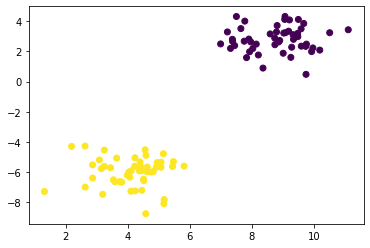

In [35]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(centers=2)
plt.scatter(X[:, 0], X[:, 1], c=y)
model = KMeans(2).fit(X)
silhouette_score(X, model.labels_)